<a href="https://colab.research.google.com/github/Dawoon-Jeong0523/Science-of-Science/blob/main/Atypical_combinations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measuring Z-Score of Combinations

The **Z-Score of Combinations** is a method proposed in:  
**Uzzi, B., Mukherjee, S., Stringer, M., & Jones, B. (2013).**  
*Atypical combinations and scientific impact.* Science, 342(6157), 468–472.

# Z-Score Calculation: Field of Study and CPC Code

In the original paper by **Uzzi, B., Mukherjee, S., Stringer, M., & Jones, B. (2013)**, the Z-score was calculated using **journal pairs** in a paper's references to measure the atypicality of combinations.

## Adapted Methodology

Instead of journal pairs, the following adaptations are used:  
1. **Field of Study (FOS) for Papers**:  
   - References are categorized based on their **Field of Study**.  
   - The combinations of FOS are used as the basis for calculating atypicality in scientific research.

2. **CPC Codes for Patents**:  
   - References in patents are categorized using **Cooperative Patent Classification (CPC) codes**.  
   - The combinations of CPC codes represent the technological domains being referenced.

## Steps to Calculate Z-Score
1. **Define Combinations**:
   - For papers: Pairs of **Field of Study (FOS)** in references (Level 2).  
   - For patents: Pairs of **CPC codes** in references (4-digit).

2. **Estimate Expected Frequency**:
   - Historical data of FOS pairs (for papers) and CPC code pairs (for patents) are used to calculate the expected frequency based on co-occurrence probabilities.

3. **Calculate Observed Frequency**:
   - Count the actual occurrences of each FOS or CPC pair in the dataset.

4. **Compute Mean and Standard Deviation**:
   - Calculate the mean ($\mu$) and standard deviation ($\sigma$) of the expected frequencies for each combination.

5. **Calculate the Z-Score**:
   - Use the formula:  

    $$
    Z = \frac{(f_{\text{obs}} - \mu)}{\sigma}
    $$

    where:
    - $f_{\text{obs}}$: Observed frequency of the combination.  
    - $\mu$: Expected frequency of the combination.  
    - $\sigma$: Standard deviation of expected frequencies.

## Interpretation of Results
- **High Positive Z-Score**:
  Indicates the FOS or CPC pair is **atypical**, suggesting a novel combination of scientific or technological domains.
  
- **Low or Negative Z-Score**:
  Suggests the combination is **typical** or conventional based on historical patterns.



## Paper

In [ ]:
dir = '/content/drive/MyDrive/Data/Pickle Data/'

In [ ]:
start_year = 1980
end_year = 2015

In [ ]:
import pandas as pd
import pickle
from tqdm import tqdm

In [ ]:
with open(dir+r'/MAG/Pickles/backward_citations_only_journal_articles_2.pkl','rb') as f:
  backward_citations = pickle.load(f)
with open(dir+'/MAG/Pickles/PaperID2DocType.pkl','rb') as f:
  PaperID2DocType = pickle.load(f)
with open(dir+r'/MAG/Pickles/PaperID2FieldofStudyID_L2.pkl','rb') as f:
  PaperID2FieldofStudyID_L2 = pickle.load(f)
with open(dir+r'/MAG/Pickles/PaperID2Year_241005.pkl','rb') as f:
  PaperID2Year = pickle.load(f)

In [ ]:
from collections import defaultdict

# Initialize Year2PaperID dictionary to store a list of PaperIDs for each year
Year2PaperID = defaultdict(list)

# Reverse the PaperID2Year dictionary: map years to a list of PaperIDs
for paper_id, year in PaperID2Year.items():
  Year2PaperID[year].append(paper_id)

In [ ]:
# Initialize an empty list to store the target Papers for the year range
target_papers = []

# Collect all PaperIDs within the specified year range
for year in range(start_year, end_year + 1):
    # Extend the list only if there are papers for the given year
    if year in Year2PaperID:
        target_papers.extend(Year2PaperID[year])

# Output the total number of target Papers in the specified year range
num_papers_in_range = len(target_papers)
num_papers_in_range

In [ ]:
# Initialize an empty list to store row data
# Papers are utility Papers
rows = []

# Loop through backward citations to extract citing and cited Papers and their years
for key, values in tqdm(backward_citations.items()):
  if key in PaperID2Year:
    citing_year = PaperID2Year[key]  # Get the citing Paper's year
    for value in values:
      if value in PaperID2Year:
        cited_year = PaperID2Year[value]  # Get the cited Paper's year
        # Append a row as a tuple (Citing Paper ID, Cited Paper ID, Citing Year, Cited Year)
        rows.append((key, value, citing_year, cited_year))

# Convert the list of tuples into a DataFrame
Ref_df = pd.DataFrame(rows, columns=['Citing', 'Cited', 'Citing_Year', 'Cited_Year'])

# Display the first few rows of the DataFrame
Ref_df.head()


In [ ]:
# Measure the execution time for resetting the index of the DataFrame
%%time

# Reset the index of Ref_df to ensure the index is continuous and drop the old index
Ref_df.reset_index(inplace=True, drop=True)

# Display the first few rows of Ref_df after resetting the index
Ref_df.head()

In [ ]:
# Measure the execution time for grouping and storing citing-cited relationships
%%time


for year in range(start_year, end_year+1):
  # Initialize an empty dictionary to store citing and cited year groupings
  D = {}

  # Group the DataFrame by 'Citing_Year'
  temp_Ref_df = Ref_df[Ref_df['Citing_Year'] == year]
  Ref_df_Y1 = temp_Ref_df.groupby(['Citing_Year'], as_index=False, sort=False)

  # Loop through each group based on 'Citing_Year'
  for name, df_group in tqdm(Ref_df_Y1):
      # Further group by 'Cited_Year'
      Ref_df_Y2 = df_group.groupby(['Cited_Year'], as_index=False, sort=False)
      # Loop through each group based on 'Cited_Year'
      for name2, df_sec_group in Ref_df_Y2:
          # Store citing and cited patent pairs for each (Citing_Year, Cited_Year)
          D[(name, name2)] = list(zip(df_sec_group['Citing'].values, df_sec_group['Cited'].values))

  # Save Data First
  with open(dir+f'/MAG/Pickles/D_241005_{year}_L2.pkl','wb') as f:
    pickle.dump(D, f)

In [ ]:
#G Measure the execution time for building the original dictionary of citing-cited relationships
%%time

# Import defaultdict for easier handling of dictionary lists
from collections import defaultdict


for year in range(start_year, end_year+1):
  # Initialize an empty defaultdict to store citing-to-cited relationships
  Ori_Dict = defaultdict(list)

  temp_Ref_df = Ref_df[Ref_df['Citing_Year'] == year]

  # Extract Citing and Cited columns from Ref_df into lists
  Citing_List = list(temp_Ref_df['Citing'].values)
  Cited_List = list(temp_Ref_df['Cited'].values)

  # Get the length of the lists
  List_Len = len(Citing_List)

  # Loop through each pair of citing and cited patents and store the relationships in Ori_Dict
  for i in tqdm(range(List_Len)):
      Ori_Dict[Citing_List[i]].append(Cited_List[i])

  # Save Data First
  with open(dir+f'/MAG/Pickles/Ori_Dict_241005_{year}_L2.pkl','wb') as f:
    pickle.dump(Ori_Dict, f)

In [ ]:
%%time

# Import defaultdict for easier handling of dictionary lists
from collections import defaultdict
import random


for year in range(start_year, end_year+1):
  # Create a list of 10 defaultdicts, each with list as the default factory
  Ref_List = [defaultdict(list) for i in range(10)]

  with open(dir+f'/MAG/Pickles/D_241005_{year}_L2.pkl','rb') as f:
    D = pickle.load(f)

  # Initialize an empty dictionary to store citing-to-cited relationships
  print(year)
  # Loop through the dictionary D which contains citing-cited pairs grouped by (Citing_Year, Cited_Year)
  for k, v in tqdm(D.items()):
      # Extract citing and cited lists separately from the current pair
      origin = [i[0] for i in v]  # Citing patents
      temp = [i[1] for i in v]    # Cited patents

      # Get the length of the citing list (or cited, as both are of same length)
      cur_len = len(origin)

      # Perform 10 epochs of random shuffling and assignment
      for epoch in range(10):
          # Shuffle the cited patents (temp list)
          random.shuffle(temp)

          # Assign the shuffled cited patents to the corresponding citing patents for the current epoch
          for i in range(cur_len):
              Ref_List[epoch][origin[i]].append(temp[i])

  with open(dir+f'/MAG/Pickles/Ref_List_241005_{year}_L2.pkl','wb') as f:
    pickle.dump(Ref_List, f)

### Load and Measure Z Score

In [ ]:
start_year = 1980
end_year = 2015

with open(dir+r'/MAG/Pickles/backward_citations_only_journal_articles_2.pkl','rb') as f:
  backward_citations = pickle.load(f)

with open(dir+r'/MAG/Pickles/PaperID2Year_241005.pkl','rb') as f:
  PaperID2Year = pickle.load(f)

with open(dir+r'/MAG/Pickles/PaperID2FieldofStudyID_L2.pkl','rb') as f:
  PaperID2FieldofStudyID_L2 = pickle.load(f)

In [ ]:
PaperID2Year = {key: value for key, value in PaperID2Year.items() if key in backward_citations}

In [ ]:
# Create a DataFrame from PaperID2Year dictionary with PaperID and Year as columns
PaperID_Year_df = pd.DataFrame(PaperID2Year.items(), columns=['PaperID', 'Year'])

# Filter the DataFrame to include only rows where the Year is within the specified range
PaperID_Year_df = PaperID_Year_df[PaperID_Year_df['Year'].isin([year for year in range(start_year, end_year+1)])]

# Map the PaperID to its corresponding CPC code using PaperID2FieldofStudyID_L1 dictionary and add as a new column
PaperID_Year_df['FOS'] = PaperID_Year_df['PaperID'].map(PaperID2FieldofStudyID_L2)

PaperID_Year_df.head()

In [ ]:

%%time

# Extract the 'Year' and 'PaperID' columns from PaperID_Year_df as lists
Sel_Year_List = list(PaperID_Year_df['Year'].values)      # List of years
Sel_PaperID_List = list(PaperID_Year_df['PaperID'].values)  # List of PaperIDs

# Get the total number of elements in the lists
List_Len = len(Sel_Year_List)

# Import necessary modules
from tqdm import tqdm
from collections import defaultdict

# Initialize a defaultdict to store PaperIDs grouped by year
Year2PaperID_dict = defaultdict(list)

# Loop through the lists and populate the defaultdict with years as keys and PaperIDs as values
for i in tqdm(range(List_Len)):
    Year2PaperID_dict[Sel_Year_List[i]].append(Sel_PaperID_List[i])

In [ ]:
def cal_obs_combination(P_i, P_j, k):
    # Check if both P_i and P_j have associated FPaperID2FieldofStudyID_L1es
    if P_i in PaperID2FieldofStudyID_L1 and P_j in PaperID2FieldofStudyID_L1:
        # Retrieve FPaperID2FieldofStudyID_L1es for P_i and P_j
        J_i, J_j = PaperID2FieldofStudyID_L1[P_i], PaperID2FieldofStudyID_L1[P_j]

        # Ensure J_i <= J_j by swapping if necessary
        if J_i > J_j:
            J_i, J_j = J_j, J_i

        # Convert J_i and J_j to tuples if they are lists to make them hashable
        J_i = tuple(J_i) if isinstance(J_i, list) else J_i
        J_j = tuple(J_j) if isinstance(J_j, list) else J_j

        # Update the count in Cur_Dict for the FPaperID2FieldofStudyID_L1 pair (J_i, J_j)
        Cur_Dict[(J_i, J_j)] = Cur_Dict.get((J_i, J_j), 0) + 1

        # Update the Paper_pair dictionary with the FPaperID2FieldofStudyID_L1 pair for the key k
        if k not in Paper_pair:
            Paper_pair[k] = set()
        Paper_pair[k].add((J_i, J_j))

def cal_exp_combination(P_i, P_j, k):
    # Check if both P_i and P_j have associated FiePaperID2FieldofStudyID_L1es
    if P_i in PaperID2FieldofStudyID_L1 and P_j in PaperID2FieldofStudyID_L1:
        # Retrieve FiePaperID2FieldofStudyID_L1es for P_i and P_j
        J_i, J_j = PaperID2FieldofStudyID_L1[P_i],PaperID2FieldofStudyID_L1[P_j]

        # Ensure J_i <= J_j by swapping if necessary
        if J_i > J_j:
            J_i, J_j = J_j, J_i

        # Convert J_i and J_j to tuples if they are lists to make them hashable
        J_i = tuple(J_i) if isinstance(J_i, list) else J_i
        J_j = tuple(J_j) if isinstance(J_j, list) else J_j

        # Update the count for the pair (J_i, J_j) under key k
        Tmp_Dict[k][(J_i, J_j)] = Tmp_Dict[k].get((J_i, J_j), 0) + 1

In [ ]:
# Load Data First
with open(dir+f'/MAG/Pickles/Ref_df_241005_L2.pkl','rb') as f:
  Ref_df = pickle.load(f)

In [ ]:
from tqdm import tqdm
import numpy as np
import pickle

# Counters for logging
pas = 0  # Skip count for Papers with too many references
std_cnt = 0  # Count of cases where standard deviation is zero
mean_cnt = 0  # Count of cases where both mean and standard deviation are zero

# Loop through each year
# 241016 여기서부터 바로
for year in tqdm(range(2012, 2012+1)):
#for year in tqdm(range(1980,1981)):
  with open(dir+f'/MAG/Pickles/Ref_List_241005_{year}_L2.pkl','rb') as f:
    Ref_List = pickle.load(f)

  with open(dir+f'/MAG/Pickles/Ori_Dict_241005_{year}_L2.pkl','rb') as f:
    Ori_Dict = pickle.load(f)

  with open(dir+f'/MAG/Pickles/D_241005_{year}_L2.pkl','rb') as f:
    D = pickle.load(f)

  Paper_list = Year2PaperID_dict[year]

  Cur_Dict = {}  # Dictionary to store FOS_L1 pairs for the current data
  Tmp_Dict = [{} for i in range(10)]  # Temporary dictionaries for shuffled data (10 epochs)
  print(year)

  Paper_pair = {}  # Dictionary to store unique Paper pairs
  Z_for_year = {}  # Dictionary to store Z-scores for the year

  Paper_Z_median_list = []  # List to store median Z-scores for each Paper
  Paper_Z_10_pct_list = []  # List to store 10th percentile Z-scores for each Paper
  Z_J_Score = []  # List to store Z-scores for FOS_L1 pairs

  # Loop through the list of Papers for the current year
  for each_Paper in (Paper_list):
      if each_Paper not in Ori_Dict:  # Skip Papers that are not in Ori_Dict
          continue

      k = each_Paper
      v = Ori_Dict[each_Paper]  # List of cited Papers
      cur_len = len(v)  # Number of citations
      if cur_len > 1000:  # Skip Papers with too many citations
          pas += 1
          continue

      # Calculate FOS_L1 pairs for cited Papers
      for i in range(cur_len):
          for j in range(i):
              cal_obs_combination(v[i], v[j], k)

      # Shuffle the references and calculate for 10 epochs
      for p in range(10):
          if k in Ref_List[p]:
              tmp_v = Ref_List[p][k]
              tmp_len = len(tmp_v)
              for i in range(tmp_len):
                  for j in range(i):
                      cal_exp_combination(tmp_v[i], tmp_v[j], p)

  # Calculate Z-scores for each FOS_L1 pair
  for k2, v2 in (Cur_Dict.items()):
      obs = v2  # Observed value
      tmp_Z = []
      for i in range(10):  # Collect the shuffled values for this FOS_L1 pair
          if k2 in Tmp_Dict[i]:
              tmp_Z.append(Tmp_Dict[i][k2])
          else:
              tmp_Z.append(0)

      mean = np.mean(tmp_Z)  # Mean of shuffled values
      std = np.std(tmp_Z)  # Standard deviation of shuffled values

      if std == 0.0:  # Handle the case where standard deviation is zero
          std_cnt += 1
          if mean == 0:
              mean_cnt += 1
      if std != 0.0:  # Calculate Z-score only if std is not zero
          Z_for_year[k2] = (obs - mean) / std  # Z-score calculation
          Z_J_Score.append([year, k2[0], k2[1], Z_for_year[k2]])  # Store Z-score

  # Calculate the median and 10th percentile Z-scores for each Paper
  for each_Paper in (Paper_list):
      k = each_Paper
      Z_for_k = []
      if k in Paper_pair:
          for ee in Paper_pair[k]:
              if ee in Z_for_year:
                  Z_for_k.append(Z_for_year[ee])
      if len(Z_for_k) > 0:  # Only calculate if there are valid Z-scores
          Paper_Z_median_list.append([k, np.quantile(Z_for_k, 0.5), len(Z_for_k)])  # Median Z-score
          Paper_Z_10_pct_list.append([k, np.quantile(Z_for_k, 0.1), len(Z_for_k)])  # 10th percentile Z-score

  # Convert results to DataFrame and save as pickle files
  temp_df = pd.DataFrame(Paper_Z_median_list)
  temp_df.columns = ['PaperID', 'Atyp_Z_median', 'Valid_Pairs']
  with open(dir + f'/MAG/Pickles/PaperID2Atyp_Z_median_241005_%s_L2.pkl' % (str(year)), 'wb') as f:
      pickle.dump(temp_df, f)

  temp_df = pd.DataFrame(Paper_Z_10_pct_list)
  temp_df.columns = ['PaperID', 'Atyp_Z_10_pct', 'Valid_Pairs']
  with open(dir + f'/MAG/Pickles/PaperID2Atyp_Z_10_pct_241005_%s_L2.pkl' % (str(year)), 'wb') as f:
      pickle.dump(temp_df, f)

  temp_df = pd.DataFrame(Z_J_Score)
  temp_df.columns = ['Year', 'code1', 'code2', 'Z_score']
  with open(dir + f'/MAG/Pickles/Z_J_Score_241005_%s_L2.pkl' % (str(year)), 'wb') as f:
      pickle.dump(temp_df, f)

  # Save the Paper pairs as pickle files
  with open(dir + f'/MAG/Pickles/Paper_pair_241005_%s_L2.pkl' % (str(year)), 'wb') as f:
      pickle.dump(Paper_pair, f)


### Visualization

In [4]:
import pickle
import pandas as pd

In [5]:
start_year = 1980
end_year = 2015

In [6]:
dir = '/content/drive/MyDrive/Data/Pickle Data/'

In [7]:
with open(dir+r'/MAG/Pickles/PaperID2Year_241005.pkl','rb') as f:
  PaperID2Year = pickle.load(f)

In [8]:
# Paper
PaperID2Atyp_Z_10_pct = pd.DataFrame()
PaperID2Atyp_Z_median = pd.DataFrame()
Z_Combination_Score = pd.DataFrame()
Paper_pair = {}

for year in range(start_year, end_year+1):
  with open(dir+f'/MAG/Pickles/PaperID2Atyp_Z_median_241005_%s_L2.pkl' % (str(year)),'rb') as f:
    temp_PaperID2Atyp_Z_median = pickle.load(f)
    PaperID2Atyp_Z_median = pd.concat([PaperID2Atyp_Z_median, temp_PaperID2Atyp_Z_median])

  with open(dir+f'/MAG/Pickles/PaperID2Atyp_Z_10_pct_241005_%s_L2.pkl' % (str(year)),'rb') as f:
    temp_PaperID2Atyp_Z_10_pct = pickle.load(f)
    PaperID2Atyp_Z_10_pct = pd.concat([PaperID2Atyp_Z_10_pct, temp_PaperID2Atyp_Z_10_pct])

  with open(dir+f'/MAG/Pickles/Z_J_Score_241005_%s_L2.pkl' % (str(year)),'rb') as f:
    temp_Z_Combination_Score = pickle.load(f)
    Z_Combination_Score = pd.concat([Z_Combination_Score, temp_Z_Combination_Score])

  #with open(dir+f'/MAG/Pickles/Paper_pair_241005_%s_L2.pkl' % (str(year)),'rb') as f:
  #  temp_Paper_pair = pickle.load(f)
  #  Paper_pair.update(temp_Paper_pair)

In [9]:
PaperID2Atyp_Z_10_pct['Year'] = PaperID2Atyp_Z_10_pct['PaperID'].map(PaperID2Year)
PaperID2Atyp_Z_median['Year'] = PaperID2Atyp_Z_median['PaperID'].map(PaperID2Year)

In [10]:
temp_Z_Combination_Score

,Year,code1,code2,Z_score
0,2015,161790260,184651966,614.886346
1,2015,161790260,2779222958,-61.829430
2,2015,184651966,2779222958,-16.228771
3,2015,161790260,161790260,6702.877604
4,2015,161790260,2778695967,395.830161
...,...,...,...,...
30047427,2015,114429787,2776390293,-0.696526
30047428,2015,105572291,114429787,0.384111
30047429,2015,114429787,2781425848,0.745356
30047430,2015,71472368,2908983204,1.333333


In [11]:
PaperID2Z_Score = pd.merge(PaperID2Atyp_Z_10_pct,PaperID2Atyp_Z_median)
PaperID2Z_Score.head()

,PaperID,Atyp_Z_10_pct,Valid_Pairs,Year,Atyp_Z_median
0,2099996007,3.433759,21,1980,19.613554
1,1976850047,-3.037947,49,1980,4.500000
2,2148017488,8.579549,3,1980,46.333333
3,1986380222,-2.285003,10,1980,2.766608
4,2003814604,-2.285003,10,1980,2.766608


In [12]:
Z_Combination_Score

,Year,code1,code2,Z_score
0,1980,59375849,84999194,146.333333
1,1980,84999194,111309251,263.701168
2,1980,59375849,111309251,62.000000
3,1980,84999194,85725439,19.613554
4,1980,59375849,85725439,8.277209
...,...,...,...,...
30047427,2015,114429787,2776390293,-0.696526
30047428,2015,105572291,114429787,0.384111
30047429,2015,114429787,2781425848,0.745356
30047430,2015,71472368,2908983204,1.333333


In [13]:
Z_Combination_Score.Year.unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015])

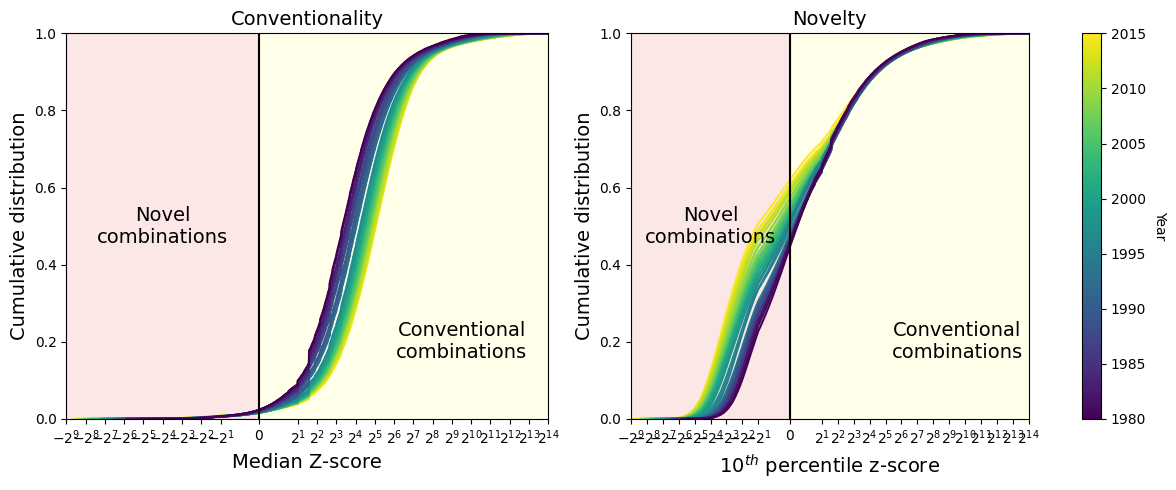

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

temp_df = PaperID2Z_Score.copy()

# Normalize the Year column to map to a colormap
year_range = temp_df["Year"].unique()
year_range.sort()
norm = Normalize(vmin=year_range.min(), vmax=year_range.max())
#cmap = plt.cm.coolwarm  # Use a blue-to-red colormap
cmap = plt.cm.viridis  # Use a viridis colormap


# Generate the palette from the colormap
palette = {year: cmap(norm(year)) for year in year_range}

# Initialize figure with 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.1]})

# Plot for left panel
sns.ecdfplot(data=temp_df,
             x="Atyp_Z_median",
             hue="Year",
             palette=palette,
             ax=axes[0],
             legend=False)
axes[0].axvline(x=0, color="black")
axes[0].axvspan(-2**9, 0, alpha=0.1, color="#e41a1c")
axes[0].axvspan(0, 2**14, alpha=0.1, color="#ffff33")
axes[0].set_ylim(0, 1)
axes[0].set_xscale("symlog", base=2)
axes[0].set_xlim(-2**9, 2**14)
axes[0].set_xlabel("Median Z-score", fontsize=14)
axes[0].set_ylabel("Cumulative distribution", fontsize=14)
axes[0].set_title(r"Conventionality", loc="center", fontsize=14)
axes[0].text(2**9.5, 0.2, "Conventional\ncombinations", ha="center", va="center", fontsize=14)
axes[0].text(-2**4, 0.5, "Novel\ncombinations", ha="center", va="center", fontsize=14)

# Plot for right panel
sns.ecdfplot(data=temp_df,
             x="Atyp_Z_10_pct",
             hue="Year",
             palette=palette,
             ax=axes[1],
             legend=False)
axes[1].axvline(x=0, color="black")
axes[1].axvspan(-2**9, 0, alpha=0.1, color="#e41a1c")
axes[1].axvspan(0, 2**14, alpha=0.1, color="#ffff33")
axes[1].set_ylim(0, 1)
axes[1].set_xscale("symlog", base=2)
axes[1].set_xlim(-2**9, 2**14)
axes[1].set_xlabel('$10^{th}$ percentile z-score', fontsize=14)
axes[1].set_ylabel("Cumulative distribution", fontsize=14)
axes[1].set_title(r"Novelty", loc="center", fontsize=14)
axes[1].text(2**9.5, 0.2, "Conventional\ncombinations", ha="center", va="center", fontsize=14)
axes[1].text(-2**4, 0.5, "Novel\ncombinations", ha="center", va="center", fontsize=14)

# Add colorbar to the right of the second panel
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable without data

cbar = fig.colorbar(sm, ax=axes[1], orientation="vertical", pad=0.1)
cbar.set_label("Year", rotation=270, labelpad=15)

# Adjust layout to fit tightly
plt.tight_layout()
plt.show()

In [21]:
Z_Combination_Score.head()

,Year,code1,code2,Z_score
0,1980,59375849,84999194,146.333333
1,1980,84999194,111309251,263.701168
2,1980,59375849,111309251,62.000000
3,1980,84999194,85725439,19.613554
4,1980,59375849,85725439,8.277209


<ipython-input-19-e0f3e14f7c73>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')


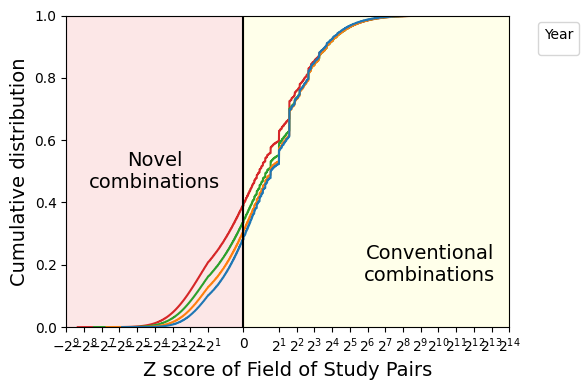

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

temp_df = Z_Combination_Score.copy()
temp_df = temp_df[temp_df['Year'].isin([1950, 1960, 1970, 1980, 1990, 2000, 2010])]

discrete_colors = sns.color_palette("tab10", n_colors=len(temp_df["Year"].unique()))
palette = {year: color for year, color in zip(temp_df["Year"].unique(), discrete_colors)}

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the ECDF
sns.ecdfplot(
    data=temp_df,
    x="Z_score",
    hue="Year",
    palette=palette,  # Use the discrete palette
    ax=ax,
    legend=True
)

# Add vertical line and shaded regions
ax.axvline(x=0, color="black")
ax.axvspan(-2**9, 0, alpha=0.1, color="#e41a1c")
ax.axvspan(0, 2**14, alpha=0.1, color="#ffff33")
ax.set_ylim(0, 1)
ax.set_xscale("symlog", base=2)
ax.set_xlim(-2**9, 2**14)
ax.set_xlabel("Z score of Field of Study Pairs", fontsize=14)
ax.set_ylabel("Cumulative distribution", fontsize=14)
ax.text(2**9.5, 0.2, "Conventional\ncombinations", ha="center", va="center", fontsize=14)
ax.text(-2**4, 0.5, "Novel\ncombinations", ha="center", va="center", fontsize=14)

# Add legend for discrete hues
ax.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to fit tightly
plt.tight_layout()
plt.show()


In [18]:
with open('/content/drive/MyDrive/Research/Disruption index/Data/Paper_df_241217.pkl', 'rb') as f:
  Paper_df = pickle.load(f)

In [20]:
temp_Paper_df = Paper_df[Paper_df['Year']>=2010]

In [21]:
temp_Paper_df.head()

,PaperID,Year,PPP,Impact,Disruption,Main FOS,Main FOS_L1,Main FOS_L0,PPP_binary,Field of Study,...,Nj,Nk,AuthorIDs,Number of Authors,Ni-Nj,Team Size,Hit_binary,Hit_paper,PatentCitation,Impact_Patent
8,2953327271,2014,Non-PPP,NaN,NaN,173608175.0,Parallel computing,Computer science,0,Computer science,...,NaN,NaN,"[2005884279, 2068258939, 2078328377]",3,NaN,Small Team,0.0,Non-Hit paper,[],0
9,14558443,2014,Non-PPP,10.0,-0.007452,173608175.0,Parallel computing,Computer science,0,Computer science,...,5.0,666.0,[],0,NaN,None,0.0,Non-Hit paper,[],0
10,15354235,2014,Non-PPP,9.0,-0.010606,23123220.0,Information retrieval,Computer science,0,Computer science,...,7.0,653.0,"[324716293, 2049021634, 3118800607]",3,NaN,Small Team,0.0,Non-Hit paper,[],0
11,2950265543,2014,Non-PPP,1.0,NaN,23123220.0,Information retrieval,Computer science,0,Computer science,...,NaN,NaN,"[324716293, 2049021634, 3118800607]",3,NaN,Small Team,0.0,Non-Hit paper,[],0
14,17001766,2011,Non-PPP,NaN,NaN,15708023.0,Humanities,Art,0,Others,...,NaN,NaN,[2684600135],1,NaN,Solo Author,0.0,Non-Hit paper,[],0


In [88]:
Hit_Paper_ids = temp_Paper_df[temp_Paper_df['Hit_binary'] == 1]['PaperID'].values
PaperID2Z_Score['Hit_binary'] = PaperID2Z_Score['PaperID'].isin(Hit_Paper_ids).astype(int)

In [89]:
temp_PaperID2Z_Score = PaperID2Z_Score[PaperID2Z_Score['Year']>=2010]

In [90]:
temp_PaperID2Z_Score.head()

,PaperID,Atyp_Z_10_pct,Valid_Pairs,Year,Atyp_Z_median,Hit_binary
17407186,1523394679,-1.637744,285,2010,83.400169,0
17407187,1538716955,10.168959,62,2010,89.340602,0
17407188,1631720620,2.758468,84,2010,21.195652,0
17407189,1844107508,-11.473210,80,2010,2.048135,0
17407190,1938344145,-3.885229,198,2010,34.101672,0


In [91]:
temp_PaperID2Z_Score = temp_PaperID2Z_Score[temp_PaperID2Z_Score['Valid_Pairs']>=2]

In [92]:
len(temp_PaperID2Z_Score[temp_PaperID2Z_Score['Hit_binary']==1])/len(temp_PaperID2Z_Score)

0.08972584758400574

In [93]:
import numpy as np
temp_med = np.quantile(temp_PaperID2Z_Score['Atyp_Z_median'].values,0.5)

In [94]:
temp_med

31.31088582382043

In [95]:
# Boolean masks for different conditions
Hit_mask = temp_PaperID2Z_Score['Hit_binary'] == 1
high_med_mask = temp_PaperID2Z_Score['Atyp_Z_median'] >=temp_med
high_novel_mask = temp_PaperID2Z_Score['Atyp_Z_10_pct'] <0

# Calculate counts for each category
high_med_high_novel = ((high_med_mask) & (high_novel_mask)).sum()
high_med_low_novel = ((high_med_mask) & (~high_novel_mask)).sum()
low_med_high_novel = ((~high_med_mask) & (high_novel_mask)).sum()
low_med_low_novel = ((~high_med_mask) & (~high_novel_mask)).sum()

# Calculate hit counts for each category
Hit_high_med_high_novel = ((Hit_mask) & (high_med_mask) & (high_novel_mask)).sum()
Hit_high_med_low_novel = ((Hit_mask) & (high_med_mask) & (~high_novel_mask)).sum()
Hit_low_med_high_novel = ((Hit_mask) & (~high_med_mask) & (high_novel_mask)).sum()
Hit_low_med_low_novel = ((Hit_mask) & (~high_med_mask) & (~high_novel_mask)).sum()

# Total number of hits
cnt = Hit_mask.sum()

# Calculate proportions, avoid dividing by zero
p1 = Hit_high_med_high_novel / high_med_high_novel
p2 = Hit_high_med_low_novel / high_med_low_novel
p3 = Hit_low_med_high_novel / low_med_high_novel
p4 = Hit_low_med_low_novel / low_med_low_novel

# Output results
print(cnt)
print(p1, p2, p3, p4)


894089
0.10158849071909147 0.07574822232892059 0.09869436798106493 0.06801692516383512


[[1. 3.]
 [1. 3.]] [[1. 1.]
 [3. 3.]]
[0.5 1.5 0.5 1.5] [0.5 0.5 1.5 1.5] 0 0.5 0.5 [0.10158849071909147, 0.07574822232892059, 0.09869436798106493, 0.06801692516383512]


Text(0.5, 0, 'Hit paper probability')

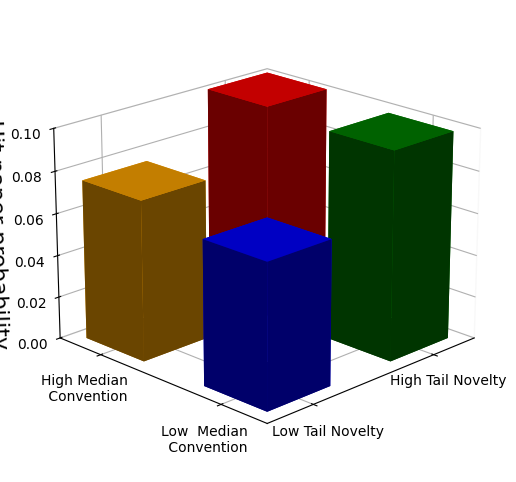

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.ticker import FixedLocator, FixedFormatter

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(projection='3d')
x, y = [2,2,0,0],[2,0,2,0]
hist, xedges, yedges = np.histogram2d(x, y, bins=2)

# Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])
print(xpos, ypos)
xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = 0

# Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = [p1, p2, p3, p4]

print(xpos, ypos, zpos, dx, dy, dz)
column_names = ['High Tail Novelty','Low Tail Novelty']
row_names = ['High Median \n Convention','Low  Median \n Convention']

ticksx = [0.75, 1.75]
ax.set_xticks(ticksx, column_names, rotation=0, fontsize=10)
ax.tick_params(axis='x', which='both', length=0, direction='in')

ticksy = [0.75, 1.75]
ax.set_yticks(ticksy, row_names, rotation=0, fontsize=10)
ax.tick_params(axis='y', which='both', length=0, direction='in')


ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',color=['red', 'orange', 'green', 'blue'])
ax.view_init(20, 45)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_zlim(0,0.1)
ax.set_zlabel('Hit paper probability', fontsize=16)
